In [934]:
from influxdb_client.client.write_api import SYNCHRONOUS
from sklearn.model_selection import train_test_split
from influxdb_client import InfluxDBClient
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pandas as pd
import requests
import joblib
import os

### 데이터 수집

In [935]:
# InfluxDB 접속 정보 불러오기
load_dotenv('secret.env')

DB_URL=os.getenv('DB_URL')
DB_TOKEN=os.getenv('DB_TOKEN')
DB_ORG=os.getenv('DB_ORG')
DB_BUCKET=os.getenv('DB_BUCKET')

In [936]:
# InfluxDB에서 주어진 측정치에 대한 데이터를 조회하여 DataFrame으로 반환.
def query_influx(measurement, place):
    client = InfluxDBClient(url=DB_URL, token=DB_TOKEN, org=DB_ORG, timeout=30_000)
    query_api = client.query_api()
    
    query = f'''
    import "date"
    import "experimental/query"
    from(bucket: "{DB_BUCKET}")
    |> range(start: date.sub(d: 2d, from: date.truncate(t: now(), unit: 1d)), stop: now())
    |> filter(fn: (r) => r["_measurement"] == "{measurement}")
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> filter(fn: (r) => r.place == "{place}")
    '''
    
    result_df = query_api.query_data_frame(org=DB_ORG, query=query)
    print(f"{place} {measurement} shape: ", result_df.shape)
    
    client.close()
    return result_df

outdoor_temperature_df = query_influx("temperature", "outdoor")
outdoor_humidity_df = query_influx("humidity", "outdoor")
temperature_df = query_influx("temperature", "class_a")
humidity_df = query_influx("humidity", "class_a")
people_count_df = query_influx("total_people_count", "class_a")
magnet_status_df = query_influx("magnet_status", "class_a")


outdoor temperature shape:  (275, 10)
outdoor humidity shape:  (275, 10)
class_a temperature shape:  (9457, 10)
class_a humidity shape:  (9457, 10)
class_a total_people_count shape:  (8273, 10)
class_a magnet_status shape:  (363, 10)


### 데이터 전처리

In [937]:
# 필요없는 컬럼 삭제 및 한국시간으로 시간대 변환
def clean_and_convert_time(df):
    df = df.drop(columns=['_start', '_stop', 'result', 'table', 'topic', 'device'])
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_convert('Asia/Seoul').dt.tz_localize(None)
    
    return df


temperature_outdoor_df = clean_and_convert_time(outdoor_temperature_df)
humidity_outdoor_df = clean_and_convert_time(outdoor_humidity_df)
temperature_class_a_df = clean_and_convert_time(temperature_df)
humidity_class_a_df = clean_and_convert_time(humidity_df)
people_count_df = clean_and_convert_time(people_count_df)
magnet_status_df = clean_and_convert_time(magnet_status_df)

In [938]:
print("info : ", temperature_outdoor_df.head(), '\n')
print("info : ", humidity_outdoor_df.head(), '\n')
print("info : ", temperature_class_a_df.head(), '\n')
print("info : ", humidity_class_a_df.head(), '\n')
print("info : ", people_count_df.head(), '\n')
print("info : ", magnet_status_df.head(), '\n')

info :                         _time _measurement    place  value
0 2024-04-23 17:38:10.170493  temperature  outdoor   18.6
1 2024-04-23 17:48:10.570783  temperature  outdoor   18.5
2 2024-04-23 17:58:09.953316  temperature  outdoor   18.4
3 2024-04-23 18:08:10.380200  temperature  outdoor   18.4
4 2024-04-23 18:18:10.775806  temperature  outdoor   18.4 

info :                         _time _measurement    place  value
0 2024-04-23 17:38:10.183036     humidity  outdoor   53.5
1 2024-04-23 17:48:10.583670     humidity  outdoor   54.0
2 2024-04-23 17:58:09.966480     humidity  outdoor   54.0
3 2024-04-23 18:08:10.393524     humidity  outdoor   54.5
4 2024-04-23 18:18:10.788553     humidity  outdoor   55.0 

info :                         _time _measurement    place  value
0 2024-04-23 09:00:09.410287  temperature  class_a   22.5
1 2024-04-23 09:00:27.623917  temperature  class_a   21.5
2 2024-04-23 09:00:49.373604  temperature  class_a   23.0
3 2024-04-23 09:01:09.410673  temperature  c

In [939]:
# resample로 1분단위로 데이터를 합치기 위해 Datetime을 인덱스로 지정
# value에 대해 1분 단위로 평균 or 마지막값 계산. resample을 수행한 후에는 Series 객체가 됨.
def resample_data(df, column, freq, method):
    df = df.set_index('_time')

    if method == 'mean':
        return df[column].resample(freq).mean()
    elif method == 'last':
        return df[column].resample(freq).last()

outdoor_temperature_summary_series = resample_data(temperature_outdoor_df, 'value', 'T', 'mean')
outdoor_humidity_summary_series = resample_data(humidity_outdoor_df, 'value', 'T', 'mean')
temperature_summary_series = resample_data(temperature_class_a_df, 'value', 'T', 'mean')
humidity_summary_series = resample_data(humidity_class_a_df, 'value', 'T', 'mean')
people_count_series = resample_data(people_count_df, 'value', 'T', 'last')
magnet_status_series = resample_data(magnet_status_df, 'value', 'T', 'last')

print(outdoor_temperature_summary_series.head(),'\n', outdoor_humidity_summary_series.head(),'\n', temperature_summary_series.head(),'\n', humidity_summary_series.head(),'\n', people_count_series.head(),'\n',magnet_status_series.head(),'\n')

_time
2024-04-23 17:38:00    18.6
2024-04-23 17:39:00     NaN
2024-04-23 17:40:00     NaN
2024-04-23 17:41:00     NaN
2024-04-23 17:42:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 17:38:00    53.5
2024-04-23 17:39:00     NaN
2024-04-23 17:40:00     NaN
2024-04-23 17:41:00     NaN
2024-04-23 17:42:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 09:00:00    22.333333
2024-04-23 09:01:00    22.750000
2024-04-23 09:02:00    22.333333
2024-04-23 09:03:00    22.750000
2024-04-23 09:04:00    22.333333
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 09:00:00    43.666667
2024-04-23 09:01:00    42.000000
2024-04-23 09:02:00    43.666667
2024-04-23 09:03:00    42.250000
2024-04-23 09:04:00    43.833333
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 09:00:00    5.0
2024-04-23 09:01:00    6.0
2024-04-23 09:02:00    6.0
2024-04-23 09:03:00    6.0
2024-04-23 09:04:00    8.0
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 09:08:00    o

In [940]:
data_df = pd.DataFrame({
    'outdoor_temperature': outdoor_temperature_summary_series,
    'outdoor_humidity': outdoor_humidity_summary_series,
    'temperature': temperature_summary_series,
    'humidity': humidity_summary_series,
    'people_count': people_count_series,
    'air_conditional': magnet_status_series
})

print(data_df)

                     outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-23 09:00:00                  NaN               NaN    22.333333   
2024-04-23 09:01:00                  NaN               NaN    22.750000   
2024-04-23 09:02:00                  NaN               NaN    22.333333   
2024-04-23 09:03:00                  NaN               NaN    22.750000   
2024-04-23 09:04:00                  NaN               NaN    22.333333   
...                                  ...               ...          ...   
2024-04-25 16:06:00                  NaN               NaN    24.733333   
2024-04-25 16:07:00                  NaN               NaN    24.900000   
2024-04-25 16:08:00            21.200001              55.0    24.766666   
2024-04-25 16:09:00                  NaN               NaN    24.850000   
2024-04-25 16:10:00                  NaN               NaN    24.700001   

                      hu

In [941]:
null_values = data_df.isnull().sum()
print('Initial null value:\n', null_values)

# 'air_conditional' 컬럼의 첫 번째 값이 결측치인 경우 'close'로 설정
if pd.isna(data_df.loc[data_df.index[0], 'air_conditional']):
    data_df.at[data_df.index[0], 'air_conditional'] = 'close'

if pd.isna(data_df.loc[data_df.index[0], 'outdoor_temperature']):
    avg_temperature = data_df['outdoor_temperature'].mean()
    data_df.at[data_df.index[0], 'outdoor_temperature'] = avg_temperature

if pd.isna(data_df.loc[data_df.index[0], 'outdoor_humidity']):
    avg_humidity = data_df['outdoor_humidity'].mean()
    data_df.at[data_df.index[0], 'outdoor_humidity'] = avg_humidity

# people_count' 컬럼에서 첫 번째 값이 결측치인 경우, 최근 유효 값으로 채우기
if pd.isna(data_df.loc[data_df.index[0], 'people_count']):
    notnull_peoplecount = data_df[data_df['people_count'].notnull()].iloc[0]['people_count']
    data_df.at[data_df.index[0], 'people_count'] = notnull_peoplecount

# 나머지 결측치 전방 채우기
data_df_filled = data_df.fillna(method='ffill', axis=0)

print('After processing null value: \n', data_df_filled.isnull().sum())

Initial null value:
 outdoor_temperature    3036
outdoor_humidity       3036
temperature               0
humidity                  0
people_count             13
air_conditional        2968
dtype: int64
After processing null value: 
 outdoor_temperature    0
outdoor_humidity       0
temperature            0
humidity               0
people_count           0
air_conditional        0
dtype: int64


In [942]:
print(data_df_filled)
print(data_df_filled.shape)

                     outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-23 09:00:00            17.699273         58.005455    22.333333   
2024-04-23 09:01:00            17.699273         58.005455    22.750000   
2024-04-23 09:02:00            17.699273         58.005455    22.333333   
2024-04-23 09:03:00            17.699273         58.005455    22.750000   
2024-04-23 09:04:00            17.699273         58.005455    22.333333   
...                                  ...               ...          ...   
2024-04-25 16:06:00            21.299999         54.500000    24.733333   
2024-04-25 16:07:00            21.299999         54.500000    24.900000   
2024-04-25 16:08:00            21.200001         55.000000    24.766666   
2024-04-25 16:09:00            21.200001         55.000000    24.850000   
2024-04-25 16:10:00            21.200001         55.000000    24.700001   

                      hu

In [943]:
# 복사본 생성
data_df_filter_by_time = data_df_filled.copy()

- 환경에 따른 에어컨 사용량 분석을 위한 전처리

In [944]:
# 날짜값 제거
data_df_filled_delete_date = data_df_filled
data_df_filled_delete_date.index = data_df_filled_delete_date.index.time
print(data_df_filled_delete_date.head())

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            17.699273         58.005455    22.333333  43.666667   
09:01:00            17.699273         58.005455    22.750000  42.000000   
09:02:00            17.699273         58.005455    22.333333  43.666667   
09:03:00            17.699273         58.005455    22.750000  42.250000   
09:04:00            17.699273         58.005455    22.333333  43.833333   

          people_count air_conditional  
09:00:00           5.0           close  
09:01:00           6.0           close  
09:02:00           6.0           close  
09:03:00           6.0           close  
09:04:00           8.0           close  


In [945]:
# air_conditional의 값이 close면 0, open이면 1로 변경
data_df_filled_delete_date['air_conditional'] = data_df_filled_delete_date['air_conditional'].map({'close': 0, 'open': 1})

print(data_df_filled_delete_date.head())
print(data_df_filled_delete_date.info)

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            17.699273         58.005455    22.333333  43.666667   
09:01:00            17.699273         58.005455    22.750000  42.000000   
09:02:00            17.699273         58.005455    22.333333  43.666667   
09:03:00            17.699273         58.005455    22.750000  42.250000   
09:04:00            17.699273         58.005455    22.333333  43.833333   

          people_count  air_conditional  
09:00:00           5.0                0  
09:01:00           6.0                0  
09:02:00           6.0                0  
09:03:00           6.0                0  
09:04:00           8.0                0  
<bound method DataFrame.info of           outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            17.699273         58.005455    22.333333  43.666667   
09:01:00            17.699273         58.005455    22.750000  42.000000   
09:02:00            17.699273         58

In [946]:
# 내외부 온도, 습도, 사람수에 따른 상관계수 계산
correlation_matrix = data_df_filled.corr()
print(correlation_matrix)

                     outdoor_temperature  outdoor_humidity  temperature  \
outdoor_temperature             1.000000         -0.831451     0.824362   
outdoor_humidity               -0.831451          1.000000    -0.716554   
temperature                     0.824362         -0.716554     1.000000   
humidity                       -0.478892          0.792043    -0.516241   
people_count                    0.481296         -0.317501     0.428980   
air_conditional                 0.343013         -0.083307    -0.007178   

                     humidity  people_count  air_conditional  
outdoor_temperature -0.478892      0.481296         0.343013  
outdoor_humidity     0.792043     -0.317501        -0.083307  
temperature         -0.516241      0.428980        -0.007178  
humidity             1.000000      0.054419         0.288187  
people_count         0.054419      1.000000         0.447536  
air_conditional      0.288187      0.447536         1.000000  


- 시간에 따른 에어컨 사용량 분석을 위한 전처리

In [947]:
# air_conditional의 값이 close면 0, open이면 1로 변경
data_df_filter_by_time['air_conditional'] = data_df_filter_by_time['air_conditional'].map({'close': 0, 'open': 1})

print(data_df_filter_by_time.head())
print(data_df_filter_by_time.info)

                     outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-23 09:00:00            17.699273         58.005455    22.333333   
2024-04-23 09:01:00            17.699273         58.005455    22.750000   
2024-04-23 09:02:00            17.699273         58.005455    22.333333   
2024-04-23 09:03:00            17.699273         58.005455    22.750000   
2024-04-23 09:04:00            17.699273         58.005455    22.333333   

                      humidity  people_count  air_conditional  
_time                                                          
2024-04-23 09:00:00  43.666667           5.0                0  
2024-04-23 09:01:00  42.000000           6.0                0  
2024-04-23 09:02:00  43.666667           6.0                0  
2024-04-23 09:03:00  42.250000           6.0                0  
2024-04-23 09:04:00  43.833333           8.0                0  
<bound method DataFrame.in

In [948]:
# 날짜별 30분 평균 에어컨 온도 사용량
data_df_filter_by_time = data_df_filter_by_time.drop(columns=['outdoor_temperature', 'outdoor_humidity', 'temperature', 'humidity', 'people_count'])
data_df_filter_by_time['air_conditional'].resample('30T').mean()

_time
2024-04-23 09:00:00    0.733333
2024-04-23 09:30:00    1.000000
2024-04-23 10:00:00    1.000000
2024-04-23 10:30:00    1.000000
2024-04-23 11:00:00    1.000000
                         ...   
2024-04-25 14:00:00    1.000000
2024-04-25 14:30:00    1.000000
2024-04-25 15:00:00    1.000000
2024-04-25 15:30:00    1.000000
2024-04-25 16:00:00    1.000000
Freq: 30T, Name: air_conditional, Length: 111, dtype: float64

In [949]:
# 날짜를 제외하고 시간 인덱스에서 시간 부분만 추출
times_only = data_df_filter_by_time['air_conditional'].resample('30T').mean().index.time

# 시간을 DataFrame의 새 인덱스로 설정
resampled_data = data_df_filter_by_time['air_conditional'].resample('30T').mean()
resampled_data.index = times_only

# 시간을 기준으로 그룹화하고 각 그룹의 평균을 계산
grouped_by_time = resampled_data.groupby(resampled_data.index).mean()

print(grouped_by_time)

00:00:00    0.366667
00:30:00    0.000000
01:00:00    0.000000
01:30:00    0.000000
02:00:00    0.000000
02:30:00    0.000000
03:00:00    0.000000
03:30:00    0.000000
04:00:00    0.000000
04:30:00    0.000000
05:00:00    0.000000
05:30:00    0.000000
06:00:00    0.000000
06:30:00    0.000000
07:00:00    0.000000
07:30:00    0.000000
08:00:00    0.000000
08:30:00    0.100000
09:00:00    0.511111
09:30:00    0.333333
10:00:00    0.333333
10:30:00    0.333333
11:00:00    0.333333
11:30:00    0.333333
12:00:00    0.333333
12:30:00    0.533333
13:00:00    0.666667
13:30:00    0.666667
14:00:00    0.811111
14:30:00    1.000000
15:00:00    1.000000
15:30:00    1.000000
16:00:00    1.000000
16:30:00    1.000000
17:00:00    1.000000
17:30:00    0.750000
18:00:00    0.500000
18:30:00    0.500000
19:00:00    0.500000
19:30:00    0.500000
20:00:00    0.500000
20:30:00    0.500000
21:00:00    0.500000
21:30:00    0.500000
22:00:00    0.500000
22:30:00    0.500000
23:00:00    0.500000
23:30:00    0

### 데이터 시각화

- 환경에 따른 에어컨 사용량 분석

/home/gahyoung/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


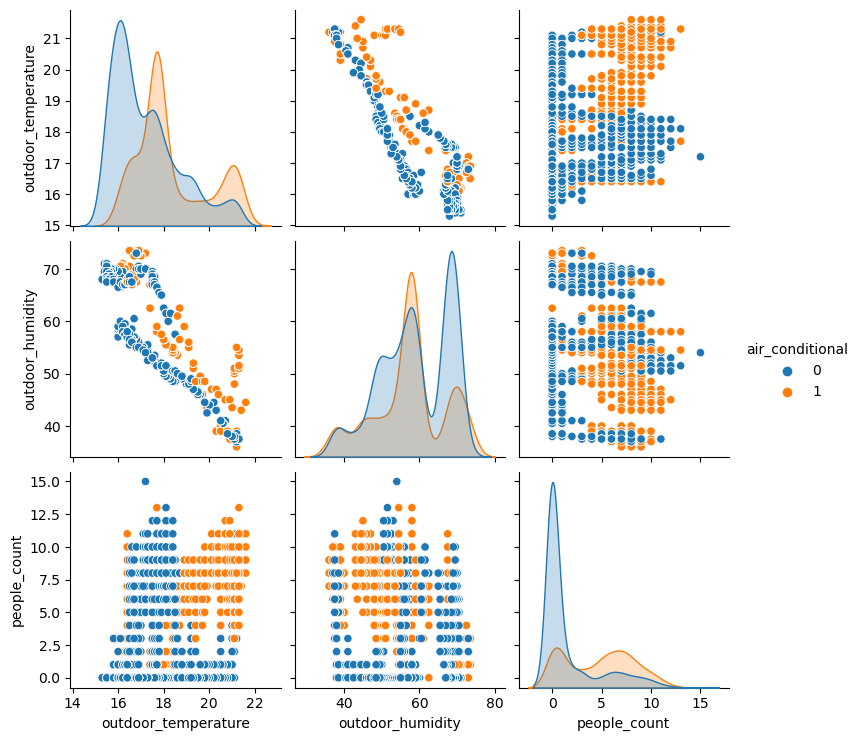

In [950]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 그리기
sns.pairplot(data_df_filled_delete_date, hue='air_conditional', vars=['outdoor_temperature', 'outdoor_humidity', 'people_count'])
plt.show()

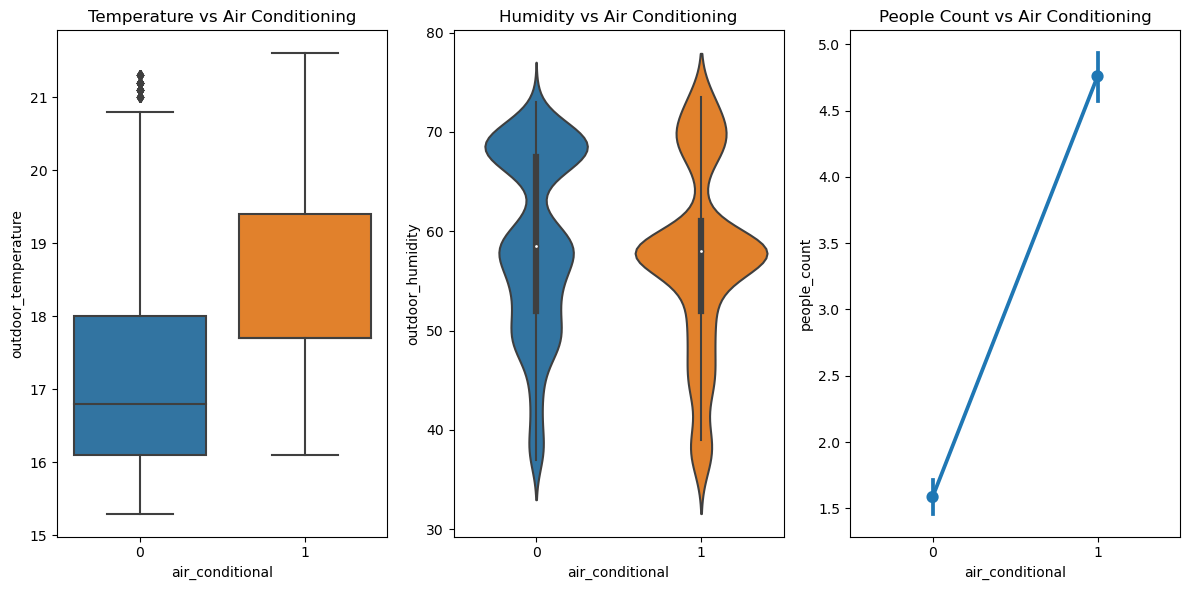

In [951]:
# 데이터 세트 설정
data = data_df_filled_delete_date

# 1. 온도와 에어컨의 상관관계 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x='air_conditional', y='outdoor_temperature', data=data)
plt.title('Temperature vs Air Conditioning')

# 2. 습도와 에어컨의 상관관계 시각화
plt.subplot(1, 3, 2)
sns.violinplot(x='air_conditional', y='outdoor_humidity', data=data)
plt.title('Humidity vs Air Conditioning')

# 3. 재실 인원과 에어컨의 상관관계 시각화
plt.subplot(1, 3, 3)
sns.pointplot(x='air_conditional', y='people_count', data=data)
plt.title('People Count vs Air Conditioning')

plt.tight_layout()
plt.show()


- 시간에 따른 에어컨 사용량 분석

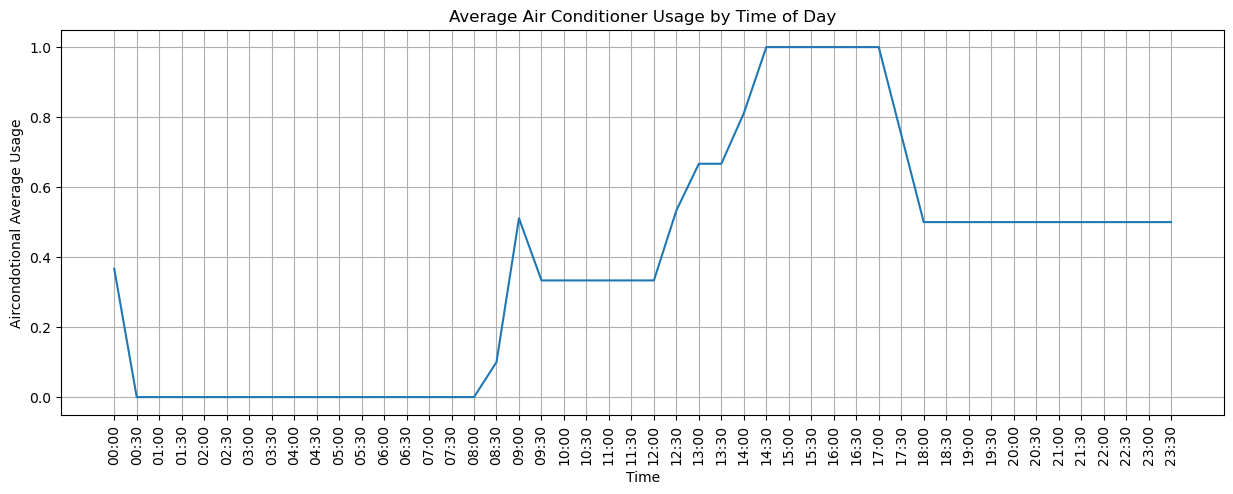

In [952]:
# grouped_by_time 인덱스를 하루 중 분으로 변환
minutes_since_midnight = [t.hour * 60 + t.minute for t in grouped_by_time.index]

# 데이터 시각화
fig, ax = plt.subplots(figsize=(15, 5))

# 선 그래프 그리기
ax.plot(minutes_since_midnight, grouped_by_time.values)

# 제목 및 라벨 설정
ax.set_title('Average Air Conditioner Usage by Time of Day')
ax.set_xlabel('Time')
ax.set_ylabel('Aircondotional Average Usage')

# x축 눈금 라벨 설정
# x축 눈금을 시간:분 형태로 표시
ax.set_xticks(minutes_since_midnight)  # 눈금 설정
ax.set_xticklabels([f'{t.hour:02}:{t.minute:02}' for t in grouped_by_time.index], rotation=90)

# 그리드 추가
ax.grid(True)

# 그래프 보여주기
plt.show()


### 분석 결과
1. 환경에 따른 에어컨 사용량 분석 : outdoor_temperature 또는 outdoor_humidity가 높을때 people_count가 함께 높을수록 에어컨을 키는 빈도가 늘어난다.
2. 시간에 따른 에어컨 사용량 분석 : 학생들이 입실하는 오전 9시, 점심시간이후이 12시부터 에어컨 사용량이 늘어난다. 학원이 마치는 시간인 6시 이후부터는 사용량이 줄어들다가 12시 반 이후가 되면 에어컨이 꺼질 확률이 높다.

### 모델링
1. 데이터 분할

In [953]:
# 훈련데이터와 테스트 데이터 분리
X = data_df_filled[['outdoor_temperature', 'outdoor_humidity','temperature', 'humidity', 'people_count']]
y = data_df_filled['air_conditional']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. 모델 훈련 및 평가

In [954]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 데이터 준비: X는 온도와 습도, y는 에어컨의 ON/OFF 상태
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# 모델 평가
from sklearn.metrics import accuracy_score
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

In [955]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 성능 평가
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

In [956]:
# XG 부스트
import xgboost as xgb

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 학습
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# 예측 및 성능 평가
xgboost_predictions = xgboost_model.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, xgboost_predictions)

In [957]:
print("LogisticRegression Accuracy:", log_reg_accuracy)
print("RandomForest Accuracy:", rf_accuracy)
print("XGBoost Accuracy:", xgboost_accuracy)

LogisticRegression Accuracy: 0.8838612368024132
RandomForest Accuracy: 0.995475113122172
XGBoost Accuracy: 0.9939668174962293


In [958]:
print(y.value_counts())

0    1950
1    1361
Name: air_conditional, dtype: int64


In [959]:
from sklearn.metrics import classification_report

print(classification_report(y_test, log_reg_predictions))
print(classification_report(y_test, rf_predictions))
print(classification_report(y_test, xgboost_predictions))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       371
           1       0.89      0.85      0.87       292

    accuracy                           0.88       663
   macro avg       0.88      0.88      0.88       663
weighted avg       0.88      0.88      0.88       663

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       371
           1       1.00      0.99      0.99       292

    accuracy                           1.00       663
   macro avg       1.00      1.00      1.00       663
weighted avg       1.00      1.00      1.00       663

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       371
           1       1.00      0.99      0.99       292

    accuracy                           0.99       663
   macro avg       0.99      0.99      0.99       663
weighted avg       0.99      0.99      0.99       663



3. 모델 선택

In [960]:
# 모델 저장 경로와 파일 이름 설정
MODEL_NAME = 'air_conditional_ai_model.joblib'
MODEL_PATH = './' 

# 모델 저장
joblib.dump(rf_model, MODEL_PATH + MODEL_NAME)

['./air_conditional_ai_model.joblib']

### NHN Cloud Object Storage에 모델 업로드

In [961]:
class ObjectService:
    def __init__(self, storage_url, token_id):
        self.storage_url = storage_url
        self.token_id = token_id

    def _get_url(self, container, object):
        return '/'.join([self.storage_url, container, object])

    def _get_request_header(self):
        return {'X-Auth-Token': self.token_id}

    def upload(self, container, object, object_path):
        req_url = self._get_url(container, object)
        req_header = self._get_request_header()

        path = '/'.join([object_path, object])
        with open(path, 'rb') as f:
            return requests.put(req_url, headers=req_header, data=f.read())


if __name__ == '__main__':

    STORAGE_URL = os.getenv('STORAGE_URL')
    ACCESS_TOKEN_ID = os.getenv('ACCESS_TOKEN_ID')
    CONTAINER_NAME = os.getenv('CONTAINER_NAME')
    OBJECT_PATH = '.' 
    
    obj_service = ObjectService(STORAGE_URL, ACCESS_TOKEN_ID)

    obj_service.upload(CONTAINER_NAME, MODEL_NAME, OBJECT_PATH)